<a href="https://colab.research.google.com/github/hida0/ESAA-2022-2/blob/HW/Week12_HW1_%EC%BD%98%ED%85%90%EC%B8%A0_%EA%B8%B0%EB%B0%98_%ED%95%84%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 개념 필사
(파이썬 머신러닝 완벽 가이드 ch9. 5 pg. 579~590)

## 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트
TMDB 5000 영화 데이터 세트는 유명한 영화 데이터 정보 사이트인 IMDB의 많은 영화 중 주요 5000개 영화에 대한 메타 정보를 새롭게 가공하여 캐글에 제공하는 데이터 세트이다. 이 데이터 세트에 기반하여 콘텐츠 기반 필터링을 수행한다.

### 1. 장르 속성을 이용한 영화 콘텐츠 기반 필터링
- 콘텐츠 기반 필터링은 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것이다.
- 영화(또는 상품/서비스) 간의 **유사성을 판단하는 기준**이 영화를 **구성하는 다양한 콘텐츠를 기반으로 하는 방식**이 바로 **콘텐츠 기반 필터링**이다.
- **콘텐츠 기반 필터링 추천 시스템**을 영화를 선택하는데 중요한 요소인 **영화 장르 속성을 기반**으로 만든다.
- **장르 칼럼 값의 유사도를 비교**한 뒤, 그중 높은 평점을 가지는 영화를 추천하는 방식이다.

### 2. 데이터 로딩 및 가공
- 장르 속성을 이용하여 콘텐츠 기반 필터링을 수행한다.
- 데이터는 4803개의 레코드와 20개의 피처로 구성되어 있다. 영화 제목, 개요, 인기도, 평점, 투표 수, 예산, 키워드 등 영화에 대한 다양한 메타 정보를 가지고 있다.
- 이중 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출하여 새로운 데이터를 만든다. 추출할 주요 칼럼은 `id`, 영화제목 `title`, 영화가 속한 여러 가지 장르인 `genres`, 평균 평점인 `vote_average`, 평점 투표 수인 `vote_count`, 영화의 인기를 나타내는 `popularity`, 영화를 설명하는 주요 키워드 문구인 `keywords`, 영화에 대한 개요 설명인 `overview`이다.


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

movies=pd.read_csv('/content/drive/MyDrive/ESAA/data/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [ ]:
movies_df=movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

### 2. 데이터 로딩 및 가공
- 이때 `genres`, `keywords` 등의 칼럼을 보면 [{"id":28, "name":"Action"},{"id":12, "name":"Adventure"}]와 같이 **리스트 내부에 여러 개의 딕셔너리가 있는 형태의 문자열**로 표기되어 있으며, 이는 한꺼번에 여러 개의 값을 표현하기 위한 표기 방식이다.
- 먼저 해당 칼럼이 어떤 형태로 되어있는지 확인한다. `genres` 칼럼은 **여러 개의 개별 장르 데이터**를 가지고 있고, **개별 장르의 명칭은 딕셔너리의 키인 'name'으로 추출**할 수 있다. `keywords` 칼럼도 마찬가지다.
- `genres` 칼럼의 **문자열을 분해**해서 **개별 장르를 파이썬 리스트 객체로 추출**한다.
- 파이썬 **`ast`** 모듈의 **`literal_eval()`** 함수를 이용하면 이 **문자열을** 문자열이 의미하는 **list[dict1, dict2] 객체로** 만들 수 있다. 
- Series 객체의 **`apply()`**에 **`literal_eval()`**를 적용하여 **문자열을 객체로 변환**한다. 이제 `genres, keywords` 칼럼은 문자열이 아니라, **실제 리스트 내부에 여러 장르 딕셔너리로 구성된 객체**를 가진다.
---
- 다음으로 ['Action', 'Adventure']와 같은 **장르명만 리스트 객체로 추출**한다. 
- `genres` 칼럼에서 **'name' 키에 해당하는 값을 추출**하기 위해 `apply lambda` 식을 이용한다.
- **`apply(lambda x: [y['name'] for y in x])`**를 적용하면, **리스트 내의 여러 개의 딕셔너리에서 'name' 키에 해당하는 값을 찾아 이를 리스트 객체로 변환**한다.

In [ ]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


In [ ]:
from ast import literal_eval
movies_df['genres']=movies_df['genres'].apply(literal_eval)
movies_df['keywords']=movies_df['keywords'].apply(literal_eval)

In [ ]:
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {...","[{'id': 1463, 'name': 'culture clash'}, {'id': 2964, 'name': 'future'}, {'id': 3386, 'name': 'sp..."


In [ ]:
movies_df['genres']=movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords']=movies_df['keywords'].apply(lambda x: [y['name'] for y in x])

In [ ]:
movies_df[['genres', 'keywords']][:2]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."
1,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india trading company, love of one's life, traitor, ship..."


### 3. 장르 콘텐츠 유사도 측정
- genres 칼럼은 여러 개의 개별 장르가 리스트로 구성되어 있다. 이 여러 개의 장르들의 장르별 유사도를 측정한다.
- 장르별 유사도를 측정하는 가장 간단한 방법은 문자열로 변경한 뒤, **`CountVectorizer`**로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교하는 것이다.
- genres 칼럼을 기반으로 하는 콘텐츠 기반 필터링은 다음과 같은 단계로 구현한다.
 - **문자열로 변환된 genres 칼럼**을 **Count 기반으로 피처 벡터화** 변환한다.
 - genres 문자열을 **피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교**한다. 이를 위해 데이터 세트의 **레코드별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체를 생성**한다.
 - 장르 유사도가 높은 영화 중에 평점이 높은 순서로 영화를 추천한다.
---
- 먼저 genres 칼럼을 문자열로 변환한 뒤 사이킷런의 **`CountVectorizer`**를 이용하여 피처 벡터 행렬로 만든다. 
- 리스트 객체 값으로 구성된 genres 칼럼을 **`apply(lambda x: (' ').join(x))`**를 적용하여 **개별 요소를 공백 문자로 구분하는 문자열로 변환**하고, 별도의 칼럼인 genres_literal로 저장한다.
- **`CountVectorizer`**로 변환하여 4803개의 레코드와 276개의 개별 단어 피처로 구성된 피처 벡터 행렬이 만들어졌다.
- 생성된 피처 벡터 행렬에 사이킷런의 **`cosine_similarity()`**를 이용하여 **코사인 유사도를 계산**한다. 
- **`cosine_similarity()`** 함수는 간략하게 설명하면, 아래의 그림과 같이 기준 행과 비교 행의 코사인 유사도를 행렬 형태로 반환하는 함수이다.
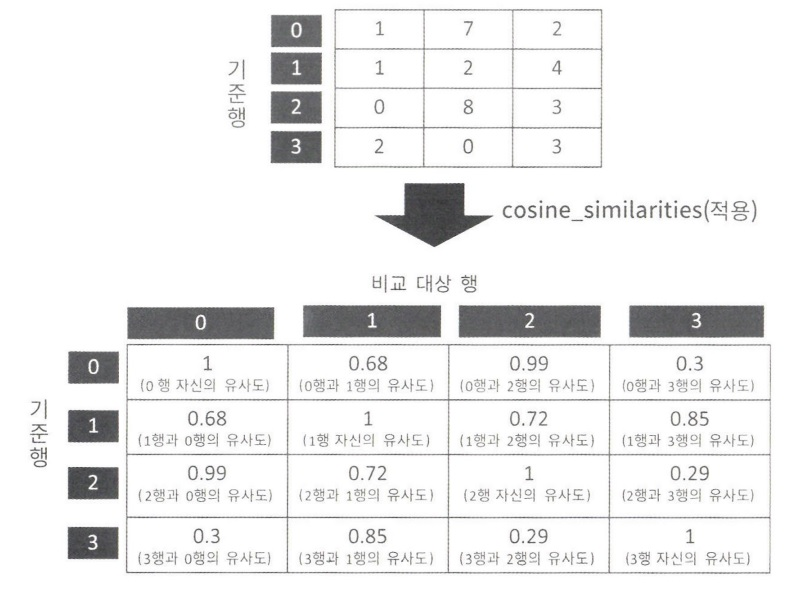

In [ ]:
#CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal']=movies_df['genres'].apply(lambda x: (' ').join(x))
movies_df['genres_literal'].head(3)

0    Action Adventure Fantasy Science Fiction
1                    Adventure Fantasy Action
2                      Action Adventure Crime
Name: genres_literal, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat=count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


### 3. 장르 콘텐츠 유사도 측정
- 피처 벡터화된 행렬에 **`cosine_similarity()`**를 적용한 코드는 다음과 같다. 반환된 코사인 유사도 행렬의 크기와 앞 2개 데이터만 추출한다.
- **`cosine_similarity()`**로 생성된 genre_sim 객체는 movies_df의 **genres_literal 칼럼을 피처 벡터화한 행렬(genre_mat) 데이터의 행(레코드)별 유사도 정보**를 가지고 있으며, 결국 **movies_df의 행별 장르 유사도 값**을 가지고 있는 것이다.
- 장르 기준으로 콘텐츠 기반 필터링을 수행하려면 movies_df의 **개별 레코드에 대해서 가장 장르 유사도가 높은 순으로 다른 레코드를 추출**해야 하므로, 이를 위해 genre_sim 객체를 이용한다.
- genre_sim 객체의 기준 행별로 **비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 값을 추출**한다. **`argsort()[:, ::-1]`**을 이용하면 유사도가 높은 순으로 정리된 genre_sim 객체의 비교 행 위치 인덱스 값을 쉽게 얻을 수 있다.
- **`genre_sim.argsort()[:, ::-1]`**을 사용하여 높은 순으로 정렬된 비교 행 위치 인덱스 값을 가져오고, 그중에 0번과 1번 레코드의 비교 행 위치 인덱스 값만 샘플로 추출한다.
- 반환된 0번 레코드의 [ 0 3494  813 ... 3038 3037 2401 ] 가 의미하는 것은 0번 레코드의 경우 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고, 그 다음이 813번 레코드이며, 2401번 레코드와 가장 유사도가 낮다는 뜻이다.
- 이제 genre_sim_sorted_ind 객체는 **각 레코드의 장르 코사인 유사도가 가장 높은 순으로 정렬된 타 레코드의 위치 인덱스 값**을 가지고 있다. 
- 이 위치 인덱스를 이용하여 언제든지 특정 레코드와 코사인 유사도가 높은 다른 레코드를 추출할 수 있다.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
genre_sim=cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


In [ ]:
genre_sim_sorted_ind=genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:2])

[[   0 3494  813 ... 3038 3037 2401]
 [ 262    1  129 ... 3069 3067 2401]]


### 4. 장르 콘텐츠 필터링을 이용한 영화 추천
- 장르 유사도에 따라 영화를 추천하는 함수 **find_sim_movie()**를 생성한다. 이 함수는 인자로 기반 데이터인 movies_df, 레코드별 장르 코사인 유사도 인덱스를 가지고 있는 genre_sim_sorted_ind, 고객이 선정한 추천 기준이 되는 영화 제목, 추천할 영화 건수를 입력하면 추천 영화 정보를 가지는 DataFrame을 반환한다.
- find_sim_movie() 함수를 이용하여 영화 '대부'와 장르별로 유사한 영화 10개를 추천한다. 
- '대부 2편', '좋은 친구들'과 같이 비슷한 유형의 추천해야할 영화들이 잘 뽑혔다.
- 그러나 'Light Sleeper', 'Mi Amearica' 등과 같이 추천하기에는 이해하기 어려운 영화와, 평점이 매우 낮은 영화도 뽑히므로 개선이 필요하다.

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    #인자로 입력된 movies_df에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
    title_movie=df[df['title']==title_name]

    #title_name을 가진 DataFrame의 index 객체를 ndarray로 반환하고, 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
    title_index=title_movie.index.values
    similar_indexes=sorted_ind[title_index, :(top_n)]

    #추출된 2차원 데이터 top_n_index 출력하고, DataFrame에서 index로 사용하기 위해 1차원 array로 변경
    print(similar_indexes)
    similar_indexes=similar_indexes.reshape(-1)

    return df.iloc[similar_indexes]

In [ ]:
similar_movies=find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', top_n=10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


### 4. 장르 콘텐츠 필터링을 이용한 영화 추천
- 이번에는 일단 좀 더 많은 후보군을 선정한 뒤에 **영화의 평점에 따라 필터링하여 최종 추천하는 방식**으로 변경한다.
- 영화의 평점 정보인 'vote_average' 값을 이용하는데, 이때 주의해야할 점이 있다. 이 값은 0부터 10점 만점까지의 점수로 되어있는데 여러 관객이 평가한 평점을 평균한 것이다. 그런데 1명, 2명의 **소수 관객이 특정 영화에 만점이나 매우 높은 평점을 부여하여 왜곡된 데이터**를 가지고 있다. 
- 이를 확인하기 위해 `sort_values()`를 이용하여 평점(vote_average) 오름차순으로 movies_df를 정렬하여 10개만 출력한다.
- 이름도 들어본 적 없는 영화가 평가 횟수가 매우 작은데 높은 평점을 받아 명작보다 더 높은 평점으로 존재한다. 이와 같은 **왜곡된 평점 데이터를 회피할 수 있도록 평점에 평가 횟수를 반영할 수 있는 새로운 평가 방식이 필요**하다.


In [ ]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


### 4. 장르 콘텐츠 필터링을 이용한 영화 추천
- 유명한 영화 평점 사이트인 IMDB에서는 **평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating) 방식을 사용**한다. 
- 가중 평점의 공식은 다음과 같다. 가중 평점 = $(v/(v+m))*R+(m/(v+m))*C$
 - v: 개별 영화에 평점을 투표한 횟수, movies_df의 'vote_count'
 - m: 평점을 부여하기 위한 최소 투표 횟수, 투표 횟수에 따른 가중치를 직접 조절하는 역할로, m 값을 높이면 평점 투표 횟수가 많은 영화에 더 많은 가중 평점을 부여
 - R: 개별 영화에 대한 평균 평점, movies_df의 'vote_average'
 - C: 전체 영화에 대한 평균 평점, movies_df['vote_average'].mean()
- m 값을 전체 투표 횟수에서 상위 60%에 해당하는 횟수를 기준으로 정하고, **`qunatile(0.6)`**으로 추출하여 가중 평점 방식으로 새롭게 평점을 부여한다.
---
- 기준 평점을 새로운 가중 평점으로 변경하는 함수 **weighted_vote_average()**를 생성하고, 이를 이용하여 새로운 평점 정보인 'vote_weighted' 값을 만든다.
- 이 함수는 DataFrame의 레코드를 인자로 받아 이 레코드의 vote_count와 vote_average, 미리 추출된 C와 m 값을 적용하여 **레코드별 가중 평점을 반환**한다.
- weighted_vote_average() 함수를 movies_df의 `apply()` 함수의 인자로 입력하여 **가중 평점을 계산**한다.
- 이렇게 계산한 가중 평점 칼럼인 weighted_vote이 높은 순으로 상위 10개의 영화를 추출한다.

In [ ]:
C=movies_df['vote_average'].mean()
m=movies_df['vote_count'].quantile(0.6)
print("C: ", round(C, 3), 'm: ', round(m, 3))

C:  6.092 m:  370.2


In [ ]:
percentile=0.6
C=movies_df['vote_average'].mean()
m=movies_df['vote_count'].quantile(percentile)

def weighted_vote_average(record):
    v=record['vote_count']
    R=record['vote_average']
    return ( (v/(v+m))*R+(m/(v+m))*C )

In [ ]:
movies_df['weighted_vote']=movies_df.apply(weighted_vote_average, axis=1)

In [ ]:
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


### 4. 장르 콘텐츠 필터링을 이용한 영화 추천
- 이제 새롭게 정의된 평점 기준에 따라서 영화를 추천한다.
- **장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선**정한 뒤에, **weightd_vote 칼럼의 값이 높은 순으로 top_n만큼 추출**하는 방식으로 **find_sim_movie()** 함수를 변경한다.
- 변경한 find_sim_movie() 함수를 이용하여 다시 한번 '대부'와 유사한 영화를 콘텐츠 기반 필터링 방식으로 추천한다.

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    #인자로 입력된 movies_df에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
    title_movie=df[df['title']==title_name]
    #title_name을 가진 DataFrame의 index 객체를 ndarray로 반환하고, 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
    title_index=title_movie.index.values

    #top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
    similar_indexes=sorted_ind[title_index, :(2*top_n)]
    #추출된 2차원 데이터 top_n_index 출력하고, DataFrame에서 index로 사용하기 위해 1차원 array로 변경
    similar_indexes=similar_indexes.reshape(-1)
    #기준 영화 인덱스는 제외
    similar_indexes=similar_indexes[similar_indexes!=title_index]

    #top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n개만큼 추출
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

In [ ]:
similar_movies=find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', top_n=10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
